In [15]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

from auxiliary import *

# Methodology

- Overview 
- Algorithm Description 
- <span style="color:red">Summary of Theoretical Results</span>
- The Algorithm in Action 
- What Comes Next? 

## Overview 

In this section of our student project we will elaborate further on the details of the Causal Tree algorithm. For a rigorous discussion one first needs to introduce the classical regression tree algorithm first proposed in [Breiman et al. 1984](https://books.google.de/books/about/Classification_and_Regression_Trees.html?id=JwQx-WOmSyQC&redir_esc=y) (see also [Hastie, Tibshirani and Friedman 2001](chrome-extension://nacjakoppgmdcpemlfnfegmlhipddanj/https://web.stanford.edu/~hastie/Papers/ESLII.pdf)). On this basis we will define in the subsection *Algorithm Description* the Causal Tree algorithm. This will be done by construction via listing exhaustively all places in the classical algorithm that need to be modified to arrive at the Causal Tree algorithm. <span style="color:red">In the following subsection, *Summary of Theoretical Results*, we state some of the most important asymptotic results from [Athey Athey THIS NEEDS TO BE UPDATED](www.link_to_athey_appers) while always prioritizing reasons why these results are of interest to us econometricians and applied economists.</span> Having gained some understanding of the inner workings of the algorithm and its asymptotic behavior we test its finite sample properties in the subsection *The Algorithm in Action*. There we will be working with artificial and real data. At last we ask *What Comes Next?*, where we will talk about Causal Forests and also even more sophisticated algorithms proposed in the recent literature. But first we must answer an even simpler question.

#### Why implement an algorithm yourself, if there already exists a good implementation? 

This question, already legitamite, gains even more weight by taking into account the amount of time it takes to write a fully-working implementation. This time then cannot be used to read through the relevant economic literature or think about economic relationships per se. However, prominent economists with a strong computer science background, such as [Susan Athey](https://athey.people.stanford.edu/) and [Sendhil Mullainathan](https://www.chicagobooth.edu/faculty/directory/m/sendhil-mullainathan), show us that the time spent might be worthwhile. The approach praised in the machine learning community is quite clear about this: implement a working version of an algorithm once, as to understand **all** the details of it, then switch to an official library. Though answering the first question, this only defers the question to a new one: *Why do economists need to understand these algorithms in such detail?* A discussion on this questions is frequently brushed aside in lectures found at economics departments, as students are not expected to have the technical skills nor invest the needed time, which renders any discussion nonsensical anyways. But, researchers will certainly still know the answer: we are trying to do economics and not data science. We are (usually) not interested in plain predictions or classifications alone, we are interested in answers to causal questions. If we formulate a query, say Q, and hope that our methods, algorithmic or not, give us an answer, say A, but in reality the method gives us the correct answer A' to the query Q', then we run the risks of mistaking A' for A. Therefore it is a necessity for the economic researcher to understand the methods she uses fully, such that she knows what the answer mechanism truly is. Interesting examples of uncovering hidden mechanism of this sort are presented in recent papers by Sendhil Mullainathan, Jon Kleinberg and others (see e.g. [Discrimination in the Age of Algorithms](https://arxiv.org/abs/1902.03731for)). 

## Algorithm Description

### Regression Tree Algorithm 

We consider the standard setting of observing a data sample $S = \{(y_i, X_i) \mid i = 1, \dots, n\}$, where $X_i = (x_{i1}, \dots, x_{iK}) \in \mathbb{R}^K$. Our goal is to fit a function to the data that describes the outcome variable $y_i$ conditional on observed characteristics $X_i$, for the given sample and for potentially new observation, respectively. Instead of modelling the function explicitly we follow the CART approach (see Breiman et. al above) to fit a tree-like structure to the data. More easily understood: we fit a high-dimensional (finite-valued) step function, where in each piecewise constant region the attained function value will simply be the unconditional mean (of $y_i$) of training observations falling in this region. Hence, the algorithms only job is to find a *good* partition of the covariate space, henceforth denoted by $\mathbb{X}$. Let us further denote an arbitrary partition of $\mathbb{X}$ by 
$$\Pi := \{\ell_1, \dots, \ell_{\#(\Pi)} \}$$
with $\ell_i \subset \mathbb{X}$ and $\cup_{i=1}^{\#(\Pi)} \ell_i = \mathbb{X}$.
For notational ease let us define an index set containing indices of all observations falling in the same region as an arbitrary $x \in \mathbb{R}^K$, given some partition $\Pi$ and sample $S$. More formally, let
$$\mathcal{I}(x, \Pi, S) := \{i \mid X_i \in \ell(x; \Pi) \text{ and } (y_i, X_i) \in S \} \,,$$
where $\ell(x; \Pi) \in \Pi$ denotes the region of the partion in which $x$ falls. Once we constructed a partition $\Pi$, our outcome prediction function is simply given by 
$$\mu(x; S, \Pi) := \frac{1}{\mid \mathcal{I}(x, \Pi, S) \mid} \sum_{i \in \mathcal{I}(x, \Pi, S)} y_i \,.$$
The reader should verify that this indeed defines a finite-valued step function. See figure 1 for an illustration of how a function of this form could look like. Note that restricting the function space to these simple functions is not necessarily prohibitive, as we know e.g. from the construction of various integrals in mathematics, that nearly arbitrary functions can be approximated by (limits of) step functions.

<Figure size 576x360 with 0 Axes>

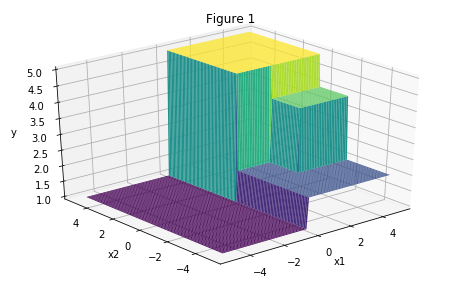

In [27]:
plot_figure1(width=12, height=7)

Let us now consider what it means to be a *good* partition in this (regression) context. In the direct comparison of multiple partitions $\{\Pi_1, \dots, \Pi_m\}$ we prefer the one that produces the smallest expected prediction error (mean squared error). That is, for a given training data sample $S_{train}$ and new data point $(y_j, X_j)$ following the same data generating process, the optimal partition $\Pi^*$ should be such that
$$\mathbb{E}\left(\left(y_j - \mu(X_j; S_{train}, \Pi^*) \right)^2 \right)$$
is minimal. Of course naively searching through the partition space (hereafter just $\mathbb{P}$) is infeasible, as the number of potential partitions explodes in the number of observations and covariates. This is where the regression tree algorithm comes in place, which is, bluntly speaking, just a function $$\pi_{tree} : \mathbb{S} \rightarrow \mathbb{P}$$ minimizing the above criterion, where $\mathbb{S}$ denotes the data-sample space. To overcome the problem of looking through too many potential partitions, the algorithm restricts attention only to a small subset of partitions. 
To be more precise, the algorithm searches for each covariate through all observed data points and estimates the loss that would occur if it would split the space by cutting the axis (currently) under inspection at the specific data point it is looking at. The covariate (axis) and data point leading to the lowest loss will be chosen for the split to occur. After the first split took place the algorithm is applied to each of the two resulting subspaces independently. This (binary) splitting process is then applied recursively until some stopping criterion is reached. It should be clear that such a binary splitting process leads to a partition consisting of (potentially high-dimensional) rectangles. 

Consider again figure 1, but now think of it as representing the regions constructed by the algorithm. In the first iteration the space was split on the first axis ($x_1$) at exactly zero. In the next iteration the left subspace was not split and the right subspace was split at the point $x_2 = 0$, etcetera. Now compare this to figure 2, representing the same information in a tree-like structure. 

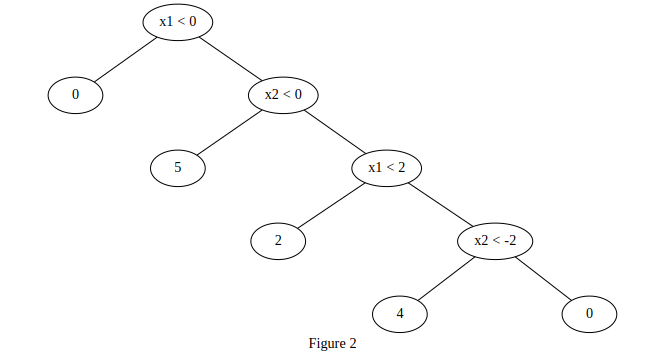

In [27]:
plot_figure2(ratio=.5, width=10, height=5)

The resulting regions $\ell \in \pi_{tree}(S)$ will be called leafs from here on. Two common stopping criteria are restricting the tree depth, i.e. number of iterations of applying the process, and minimal leaf size, that is, restricting the minimum number of observations that must be contained in a single leaf. The statistically inclined reader will quickly realize that a larger tree size (and smaller leaf size for that matter) can lead to dramatic overfitting and high variance estimators. However, going against first intuition, the solution to this problem is not cross-validating over the hyper-parameter space. It turns out that the most efficient method is given by growing very deep trees with small leaf sizes and then applying a specific pruning process, in which parts of the tree are cut off. Loosely speaking, the pruning algorithm considers a sequence of relevant subtrees and evaluates (via cross-validation) the explained variance of each subtree, while also adding a penalty for tree size to the overall estimated loss of a specific subtree. In comparison to tree-fitting, tree-pruning is vastly more complex, even relying on certain theorems to hold. This is why we will not explain the process any further (the interested reader should visit [Right Sized Tree via Pruning](https://newonlinecourses.science.psu.edu/stat508/lesson/11/11.8); note that we have yet to find more appropriate material covering this topic). 

Summarizing, the regression tree algorithm aims to find a partition of the covariate space that minimizes the variance of outcomes in the resulting leafs. This is done by clustering observations with similar outcomes using a recursive binary splitting rule. 

### Causal Tree

# <span style="color:red">Summary of Theoretical Results</span>

## The Algorithm in Action 

In [ ]:
import pandas as pd
import numpy as np

#import CausalTree 
#import auxiliary 

#X, y, D = generate_data()
#ct = CausalTree()
#ct.fit(X, y, D)

## What Comes Next? 